# Find z500 analogues of ERA5 event 
- search for analogues in ERA5 dataset
- search for analogues in CRCM5 Large Ensemble

### Packages and Directories

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import time
import dask
from dask.distributed import LocalCluster, Client, progress
import matplotlib.pyplot as plt
import os
import calendar
from collections import defaultdict
from scipy.interpolate import griddata

# my function files
import sys
sys.path.append('/home/portal/script/python/precip_Cristina/')
import functions_visualise_PrMax as fvp
import functions_analogues_LUCAFAMOSS as fan

/home/portal/script/python/precip_Cristina/functions_visualise_PrMax.py:251: SyntaxWarning: invalid escape sequence '\D'
  cbar_label = "$\Delta$Z500 (m)"
/home/portal/script/python/precip_Cristina/functions_visualise_PrMax.py:253: SyntaxWarning: invalid escape sequence '\D'
  cbar_label = "$\Delta$mslp (hPa)"


In [2]:
CERRA_dir = '/work_big/users/clima/portal/CERRA-Land/'
ERA5_dir = '/work_big/users/clima/portal/ERA5/'
CRCM5_dir = '/work_big/users/clima/portal/CRCM5-LE/'
fig_dir = '/home/portal/figures/case-studies_byNode/'

### Identify date of ERA5 event

In [3]:
# Event selection
lselect = 'alert-regions'  # 'Italy' or 'wide-region' or 'alert-regions'
no_node = 1
no_event = 1
# Upload the data
if lselect == 'wide-region':
    df_events = pd.read_excel(CERRA_dir+'events_on_wide_regions.xlsx', sheet_name=no_node-1)
elif lselect == 'alert-regions':
    df_events = pd.read_excel(CERRA_dir+'events_cum_on_above99_alert_regions.xlsx', sheet_name=no_node-1)
elif lselect == 'Italy':
    df_events = pd.read_excel(CERRA_dir+'events_on_Italy.xlsx', sheet_name=no_node-1)
time_event = df_events['Time'].iloc[no_event-1] + pd.Timedelta('12h')
doy_event =  time_event.timetuple().tm_yday
# Define lon-lat box of event
box_event = fvp.box_event_PrMax_alertregions(no_node,no_event)

print('Event time:', time_event)
print('Event DOY:', doy_event)
print('Event box:', box_event)

Event time: 2018-10-29 18:00:00
Event DOY: 302
Event box: [-5, 20, 31, 50]


In [4]:
# Define the months for analogue selection
month_event = time_event.month
months_sel = [month_event-1, month_event, month_event+1]
# Get the month names
month_names = [calendar.month_abbr[month] for month in months_sel]
# Extract the initials
str_months = ''.join([name[0] for name in month_names])

### Upload ERA5 anomaly map of event

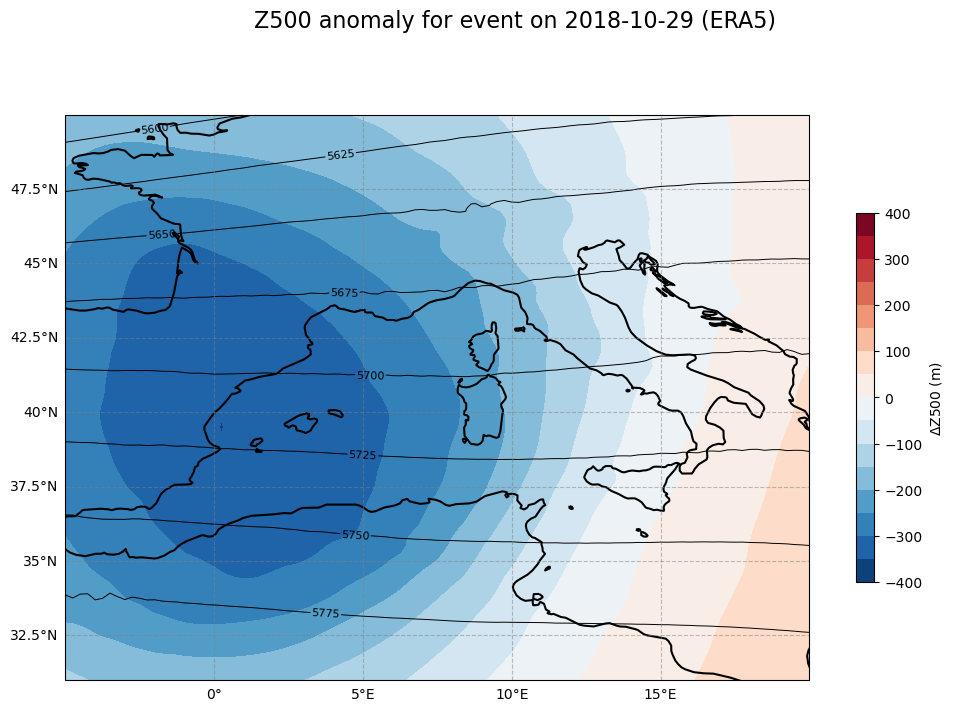

In [5]:
# Upload event mslp data
dz500_event = fvp.load_ERA5_data('z500', 'daily', time_event, box_event, l_anom=True)
z500_clim = fvp.load_ERA5_clim('z500', doy_event, box_event, l_smoothing=True)

# Plot event
fig, ax = fvp.plot_anom_event("z500", dz500_event.lon, dz500_event.lat, dz500_event.values, z500_clim)
fig.suptitle("Z500 anomaly for event on "+str(time_event)[:10]+" (ERA5)", fontsize=16)
fig.show()
fig.savefig(fig_dir+'z500_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_box-analogues.png')

#### Regrid ERA5 event anomaly to 0.5 resolution

In [7]:
# Old data
values = dz500_event.values.flatten()

# Old grid coordinates
lon_grid, lat_grid = np.meshgrid(dz500_event.lon.values, dz500_event.lat.values)
# Flatten the 2D grids into 1D arrays to produce coordinates
coordinates = np.array([lon_grid.ravel(), lat_grid.ravel()]).T

# New grid coordinates
new_lat = np.arange(box_event[2], box_event[3] + 0.5, 0.5)  # Latitude 0.5 res
new_lon = np.arange(box_event[0], box_event[1] + 0.5, 0.5)  # Longitude 0.5 res
# Create a meshgrid of the new coordinates
new_lon_grid, new_lat_grid = np.meshgrid(new_lon, new_lat)
new_coordinates = np.array([new_lon_grid.ravel(), new_lat_grid.ravel()]).T

# Regrid (linear interpolation)
dz500_event_05 = griddata(coordinates, dz500_event.values.flatten(), new_coordinates, method='linear')

# Create regridded dataset (for LE analogues)
dz500_event_05 = dz500_event_05.reshape(new_lat.shape[0], new_lon.shape[0])
dz500_event_LE = xr.DataArray(
    dz500_event_05,
    dims=["lat", "lon"],
    coords={"lat": new_lat, "lon": new_lon},
)

## Find analogues in ERA5

In [8]:
# Selection of data for analogues
# Variable
varname = 'mslp'
# Time
year_range = [2004, 2023]
years_sel = np.arange(year_range[0], year_range[1]+1)
# Quantile
qtl = 0.99

In [9]:
# Load and preprocess mslp data for analogues

# Define the file pattern for loading mslp data
file_pattern = ERA5_dir + varname +"/ERA5_"+varname+"_NH_daily_*_anom.nc"
dmslp_tmp = xr.open_mfdataset(file_pattern, combine='by_coords', parallel=True)['msl'] * 0.01
dmslp_tmp = dmslp_tmp.sel(time=dmslp_tmp.time.dt.month.isin(months_sel))
dmslp_tmp = dmslp_tmp.sel(time=dmslp_tmp.time.dt.year.isin(years_sel))

# Define and select lon lat masks (specific of each event)
lon_mask, lat_mask = fvp.lonlat_mask(dmslp_tmp.longitude.values, dmslp_tmp.latitude.values, box_event)
mask = lat_mask[:, np.newaxis] & lon_mask
mask_xr = xr.DataArray(
    mask,
    dims=["latitude", "longitude"],
    coords={"latitude": dmslp_tmp.latitude, "longitude": dmslp_tmp.longitude},
)

# Apply mask to the dataset
dmslp_sel = dmslp_tmp.where(mask_xr, drop=True)

In [10]:
# Compute euclidean distance from the event to the selected mslp data
dist = fan.function_distance(dz500_event,dmslp_sel, nan_version=False)

KeyboardInterrupt: 

In [43]:
# Select analogues based on quantile threshold
logdist = np.log(1/dist)
thresh = np.percentile(logdist, qtl*100, axis = 0)
mask_analogues = (logdist >= thresh)
dmslp_analogues = dmslp_sel.isel(time=np.where(mask_analogues)[0])
dmslp_analogues_mean = dmslp_analogues.mean(dim='time')
dmslp_analogues_mean_values = dmslp_analogues_mean.values

/tmp/ipykernel_4080130/2531337776.py:2: RuntimeWarning: divide by zero encountered in divide
  logdist = np.log(1/dist)


#### Compute mean on ERA5 analogues

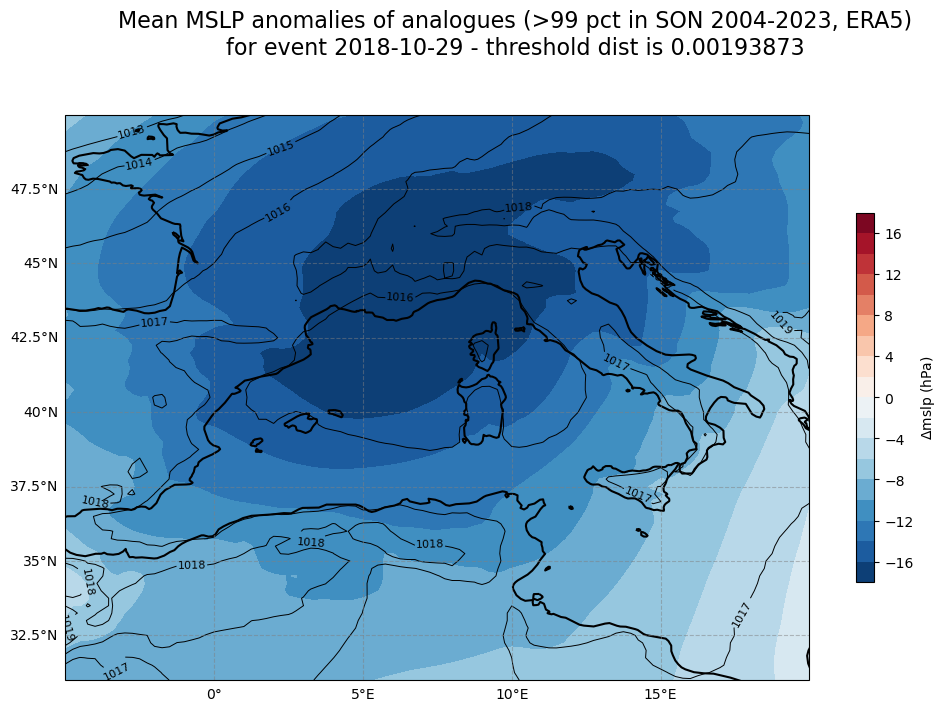

In [ ]:
# Plot analogue mean
fig, ax = fvp.plot_dz500_event(dmslp_analogues_mean.longitude, dmslp_analogues_mean.latitude, dmslp_analogues_mean_values, mslp_clim) #

fig.suptitle("Mean MSLP anomalies of analogues (>"+str(int(qtl*100))+" pct in "+str_months+' '+str(year_range[0])+'-'+str(year_range[1])+", ERA5)\nfor event "+str(time_event)[:10]+\
             " - threshold dist is "+str(1/np.exp(thresh))[:10], fontsize=16)
fig.show()
fig.savefig(fig_dir+'analogues-mslp_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_mean_'+str(int(qtl*100))+'pct_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'_ERA5.png')

## Find analogues in CRCM5

In [7]:
# Parameter selection
varname = 'psl'
year_range = [2004, 2023]
month_event = time_event.month
months_sel = [month_event-1, month_event, month_event+1]
years_sel = np.arange(year_range[0], year_range[1]+1)
no_membs = 10  # Number of members to select
# Quantile
qtl_LE = 0.99

#### File paths per member

In [8]:
# List of members
list_membs = [name for name in os.listdir(CRCM5_dir + varname) if os.path.isdir(os.path.join(CRCM5_dir + varname, name))]
list_membs = sorted(list_membs)[:no_membs]  # Select the first 'no_membs' members
# List file paths
dirs_files = [CRCM5_dir + varname + '/' + membs + '/'+ str(year) + '/res05/' for year in years_sel for membs in list_membs]
prefix_files = varname + '-anom'

# Loop through each item in the main folder
paths_files = []
for dir in dirs_files:
    # Loop through files in the subdirectory
    if len(os.listdir(dir)) != 24:
        print('Warning: missing files in', dir)
    for file in os.listdir(dir):
        file_path = os.path.join(dir, file)  # Full file path
        if os.path.isfile(file_path):  # Check if it is a file
            paths_files.append(file_path) if file.startswith(prefix_files) else None

# Create a dictionary: member -> list of files
memb_files = fvp.create_member_file_dict(paths_files, list_membs)
# print(len(memb_files['kba']))

In [9]:
# Same for clim files
# List clim file paths
dirs_files_clim = [CRCM5_dir + varname + '/' + membs + '/clim/' for membs in list_membs]
suffix_files_clim = 'clim'+str(year_range[0])+'-'+str(year_range[1])+'_sm31d_05res.nc'

# Loop through each item in the main folder
paths_files_clim = []
for dir in dirs_files_clim:
    # Loop through files in the subdirectory
    for file in os.listdir(dir):
        file_path = os.path.join(dir, file)  # Full file path
        if os.path.isfile(file_path):  # Check if it is a file
            paths_files_clim.append(file_path) if file.endswith(suffix_files_clim) else None

# Create a dictionary: member -> list of files
memb_files_clim = fvp.create_member_file_dict(paths_files_clim, list_membs)

# Sort paths for each member (by filename or full path)
for memb in memb_files_clim:
    memb_files_clim[memb].sort()

#### Open CRCM5 data

In [10]:
# Make list of datasets and add 'member' coordinate
list_ds = fvp.open_member_datasets(memb_files, combine='by_coords', expand_member_dim=True)

# ??? Check if you can open in parallel (gives error) 

# Concatenate and scale
dmslp_tmp_LE = xr.concat(list_ds, dim='member')[varname] * 0.01
print(dmslp_tmp_LE)

Opening files for member: kba


/home/portal/script/python/precip_Cristina/functions_visualise_PrMax.py:244: SyntaxWarning: invalid escape sequence '\D'
  cbar = fig.colorbar(cf, ax=ax, shrink=0.6, label="$\Delta$mslp (hPa)")


RuntimeError: Can't synchronously determine if attribute exists by name (invalid identifier type to function)

In [ ]:
for memb, files in memb_files.items():
    for f in files:
        # Check if the file can be opened
        try:
            with xr.open_dataset(f) as ds:
                ds.load()
        except Exception as e:
            print(f"File {f} has an issue: {e}")

In [ ]:
# Same for clim
# Make list of datasets and add 'member' coordinate
list_ds_clim = fvp.open_member_datasets(memb_files_clim, combine='by_coords', expand_member_dim=True)

# Concatenate and scale
dmslp_tmp_clim_LE = xr.concat(list_ds_clim, dim='member')[varname] * 0.01
print(dmslp_tmp_clim_LE)

Opening files for member: kba
Opening files for member: kbb
Opening files for member: kbc
Opening files for member: kbd
Opening files for member: kbe
Opening files for member: kbf
Opening files for member: kbg
Opening files for member: kbh
Opening files for member: kbi
Opening files for member: kbj
<xarray.DataArray 'psl' (member: 10, time: 365, lat: 69, lon: 125)> Size: 126MB
dask.array<mul, shape=(10, 365, 69, 125), dtype=float32, chunksize=(1, 1, 69, 125), chunktype=numpy.ndarray>
Coordinates:
  * member   (member) object 80B 'kba' 'kbb' 'kbc' 'kbd' ... 'kbh' 'kbi' 'kbj'
  * time     (time) object 3kB 2004-01-01 00:00:00 ... 2004-12-31 00:00:00
  * lon      (lon) float64 1kB -24.5 -24.0 -23.5 -23.0 ... 36.0 36.5 37.0 37.5
  * lat      (lat) float64 552B 30.5 31.0 31.5 32.0 32.5 ... 63.0 63.5 64.0 64.5


In [65]:
# Select the time range for the event
dmslp_tmp_LE = dmslp_tmp_LE.sel(time=dmslp_tmp_LE.time.dt.month.isin(months_sel))
dmslp_tmp_LE = dmslp_tmp_LE.sel(time=dmslp_tmp_LE.time.dt.year.isin(years_sel))
dmslp_tmp_clim_LE = dmslp_tmp_clim_LE.sel(time=dmslp_tmp_clim_LE.time.dt.month.isin(months_sel))

# Select lon lat mask for the event
lon_mask_LE, lat_mask_LE = fvp.lonlat_mask(dmslp_tmp_LE.lon.values, dmslp_tmp_LE.lat.values, box_event)
mask_LE = lat_mask_LE[:, np.newaxis] & lon_mask_LE
mask_xr_LE = xr.DataArray(
    mask_LE,
    dims=["lat", "lon"],
    coords={"lat": dmslp_tmp_LE.lat.values, "lon": dmslp_tmp_LE.lon.values},
)
dmslp_sel_LE = dmslp_tmp_LE.where(mask_xr_LE, drop=True)
dmslp_sel_clim_LE = dmslp_tmp_clim_LE.where(mask_xr_LE, drop=True)

#### Compute distances from ERA5 event and select analogues

In [ ]:
dist_LE = []
for memb in list_membs:
    print('Computing distance for member:', memb)
    # Compute euclidean distance from the event to the selected mslp data for each member
    dist_LE = np.append(dist_LE, fan.function_distance(dz500_event_LE,dmslp_sel_LE.sel(member=memb), nan_version=True))

# Convert to NumPy array
dist_LE = np.array(dist_LE)

Computing distance for member: kba
Computing distance for member: kbb
Computing distance for member: kbc
Computing distance for member: kbd
Computing distance for member: kbe
Computing distance for member: kbf
Computing distance for member: kbg
Computing distance for member: kbh
Computing distance for member: kbi
Computing distance for member: kbj


In [34]:
# Select analogues based on quantile threshold
logdist_LE = np.log(1/dist_LE)
logdist_LE[dist_LE==0.0] = -np.inf
thresh_LE = np.percentile(logdist_LE, qtl_LE*100, axis = 0)
mask_analogues_LE = (logdist_LE >= thresh_LE)
dmslp_sel_LE_stacked = dmslp_sel_LE.stack(member_time=('member', 'time'))
dmslp_analogues_LE = dmslp_sel_LE_stacked.isel(member_time=np.where(mask_analogues_LE)[0])
dmslp_analogues_LE_mean = np.nanmean(dmslp_analogues_LE, axis=2)

/tmp/ipykernel_4080130/130455624.py:8: RuntimeWarning: Mean of empty slice
  dmslp_analogues_LE_mean = np.nanmean(dmslp_analogues_LE, axis=2)


In [105]:
# Apply mask to find matching analogues
analogues_indices = np.where(mask_analogues_LE)[0]
analogues_coords = dmslp_sel_LE_stacked.member_time[analogues_indices]

# Unstack the coordinates to get member and day of year for each analogue
member_values = analogues_coords['member'].values
time_values = analogues_coords['time']
doy_values = time_values.dt.dayofyear.values

# Select climatology data for the analogues
doy_clim = dmslp_sel_clim_LE['time'].dt.dayofyear

for memb, doy in zip(member_values, doy_values):
    # Select for specific member and matching DOY
    mask_time = doy_clim == doy
    clim_sel = dmslp_sel_clim_LE.sel(member=memb).sel(time=mask_time).values
    if memb == member_values[0] and doy == doy_values[0]:
        clim_sum = clim_sel
    else:
        clim_sum += clim_sel
# Calculate the climatology for the analogues
clim_analogues_LE = clim_sum.squeeze() / len(analogues_indices)

In [106]:
dmslp_analogues_LE_mean.shape, clim_analogues_LE.shape

((39, 51), (39, 51))

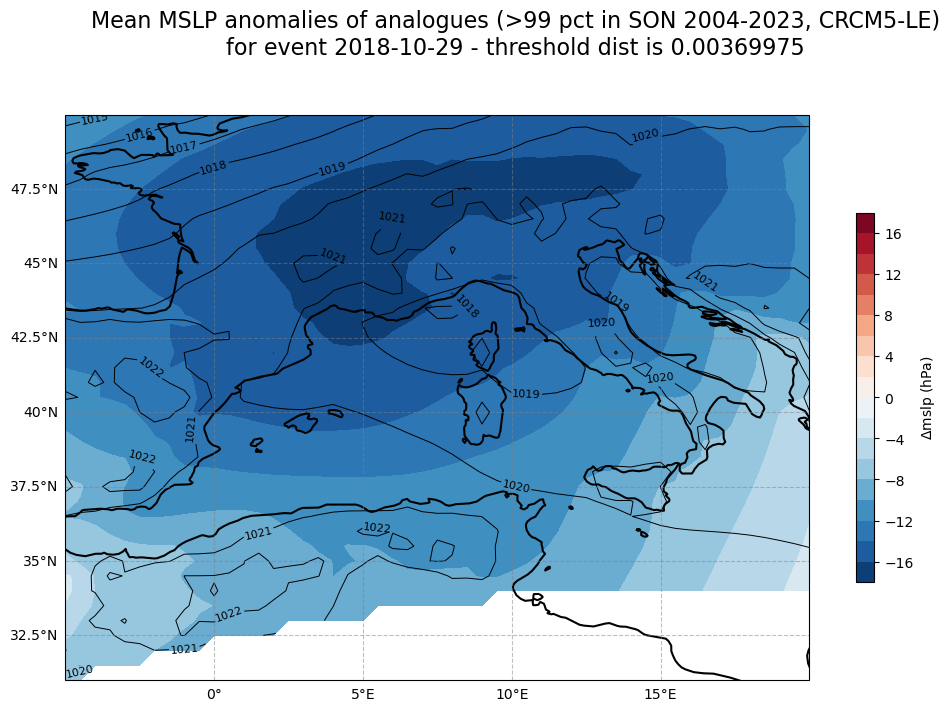

In [ ]:
# Plot LE analogue mean
fig, ax = fvp.plot_dz500_event(dmslp_analogues_LE.lon, dmslp_analogues_LE.lat, dmslp_analogues_LE_mean, clim_analogues_LE) #

fig.suptitle("Mean MSLP anomalies of analogues (>"+str(int(qtl_LE*100))+" pct in "+str_months+' '+str(year_range[0])+'-'+str(year_range[1])+", CRCM5-LE)\nfor event "+str(time_event)[:10]+\
             " - threshold dist is "+str(1/np.exp(thresh_LE))[:10], fontsize=16)
fig.show()
fig.savefig(fig_dir+'analogues-mslp_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_mean_'+str(int(qtl_LE*100))+'pct_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'_CRCM5-LE.png')